In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras as K
import pandas as pd
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import pandas as pd

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2024-04-14 01:18:28.522266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Loading The Data

In [2]:
with h5py.File("info/data/output_signal.h5", "r") as file:
    signal_data = file["events"][:]

with h5py.File("info/data/output_bg.h5", "r") as file:
    bg_data = file["events"][:]

# Subset of the Data

In [3]:
# storing signal and background data in panda DataFrame
signal = pd.DataFrame(signal_data)
background = pd.DataFrame(bg_data)

# concatenating the data frames to be part of one big set
df = pd.concat([signal, background])

# reseting the indicies
df = df.reset_index()

# creating the labels for the data sets i.e; signal = 1, background = 0 for classification
labels = np.concatenate([np.ones(signal.shape[0]), np.zeros(background.shape[0])])
labels = pd.DataFrame({'ttZ': labels})

# adding labels as a column at the end of the DataFrame
df = df.join(labels)

# shuffling the DataFrame
df_shuffled = df.sample(frac=1, random_state=42)  # 'random_state' for reproducibility
df_shuffled.head()

,index,jet_1_pt,jet_2_pt,jet_3_pt,jet_1_eta,jet_2_eta,jet_3_eta,jet_1_twb,jet_2_twb,jet_3_twb,bjet_1_pt,lep_1_pt,lep_2_pt,lep_3_pt,n_jets,n_bjets,n_leptons,met_met,H_T,ttZ
469349,469349,110.017174,89.244843,42.692078,-1.638234,-1.114363,0.334825,3,1,1,110.017174,165.685593,81.492973,32.393501,3,1,3,64.430573,585.956726,1.0
8248,8248,183.934067,125.170509,93.043922,0.185653,-1.264277,1.190622,1,4,1,125.170509,68.110207,35.741417,12.237628,4,1,3,104.903961,654.210388,1.0
699594,190559,195.334396,155.822617,39.977455,-0.860027,1.231296,2.197089,1,1,1,35.366051,184.187210,82.709946,36.546856,5,1,3,48.988052,807.437683,0.0
149760,149760,165.566879,136.009689,124.258598,0.903266,-0.343321,0.041760,5,5,1,165.566879,113.711166,112.550560,34.406342,6,2,3,172.116821,1007.604309,1.0
72006,72006,128.334076,54.510422,45.616039,-0.975434,-2.489865,-1.147104,1,1,1,32.256153,109.551361,100.125435,48.681091,6,2,3,29.693062,606.260437,1.0


In [4]:
# taking the first 30 000 rows from the shuffled DataFrame
subset_df = df_shuffled.iloc[:30000]

# splitting the labels from the rest of the dataset
X_sub = subset_df[['jet_1_pt', 'jet_2_pt', 'jet_3_pt', 'jet_1_eta', 'jet_2_eta',
       'jet_3_eta', 'jet_1_twb', 'jet_2_twb', 'jet_3_twb', 'bjet_1_pt',
       'lep_1_pt', 'lep_2_pt', 'lep_3_pt', 'n_jets', 'n_bjets', 'n_leptons',
       'met_met', 'H_T']]
y_sub = subset_df['ttZ']

# we can check the class distribution in the subset
print('ttZ events: {:.2f}%'.format(np.sum(y_sub)/len(y_sub) * 100))
print('WZ events: {:.2f}%'.format((1 - np.sum(y_sub)/len(y_sub)) * 100))

ttZ events: 68.69%
WZ events: 31.31%


# Sequential Feature Selector

https://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#example-9-selecting-the-best-feature-combination-in-a-k-range

In [5]:
# model for classification
def build_model(input_dim=None):
    model = K.Sequential([
        K.layers.Normalization(),
        K.layers.Dense(50, activation="relu", input_dim=input_dim),
        K.layers.Dense(25, activation="relu"),
        K.layers.Dense(10, activation="relu"),
        K.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# wrapper function
model = KerasClassifier(build_fn=lambda: build_model(input_dim=X_sub.shape[1]), epochs=10, batch_size=32, verbose=0)

/var/folders/3x/lv7sddxn2gg8mq0dwdcn1wg40000gn/T/ipykernel_29259/2265007354.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=lambda: build_model(input_dim=X_sub.shape[1]), epochs=10, batch_size=32, verbose=0)


In [6]:
# SFS model, will check performance from 1 feature to all 18
sfs = SFS(model, 
          k_features = (1,18),
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=5,
          verbose=0)

sfs = sfs.fit(X_sub, y_sub)

/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 432us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 399us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 419us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 396us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 393us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 430us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 408us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 403us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 397us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 404us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 406us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 396us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 437us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 388us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 1s 7ms/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 397us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 385us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 421us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 400us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 381us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 389us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 406us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 388us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 380us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 387us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 385us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 380us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 380us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 388us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 400us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 385us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 386us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 482us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 379us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 380us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 378us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 391us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 381us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 380us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 387us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 378us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 384us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 380us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 381us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 385us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 390us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 381us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 388us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 393us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 380us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 413us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 380us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 381us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 381us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 412us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 380us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 384us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 396us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 392us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 387us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 381us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 385us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 602us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 387us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 387us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 385us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 381us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 386us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 402us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 386us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 386us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 388us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 387us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 392us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 384us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 392us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 384us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 385us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 387us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 385us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 381us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 386us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 386us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 385us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 384us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 384us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 403us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 387us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 386us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 381us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 388us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 381us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 384us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 399us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 384us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 380us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 384us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 392us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 384us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 384us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 380us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 387us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 394us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 391us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 390us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 385us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 381us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 386us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 386us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 384us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 433us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 379us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 389us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 386us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 393us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 381us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 385us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 388us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 391us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 413us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 384us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 387us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 382us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 384us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 387us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 385us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 400us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 386us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 386us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 398us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 383us/step


/Users/raveel/miniconda3/envs/tf/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(


188/188 [==============================] - 0s 386us/step


best combination (ACC: 0.819): (0, 2, 3, 5, 6, 7, 8, 9, 13, 14, 15)



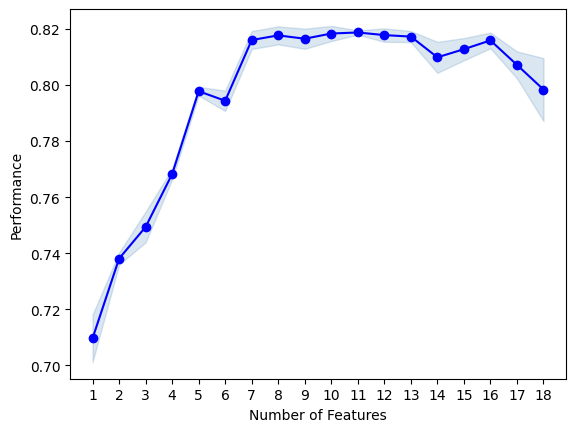

In [7]:
# plotting performance improvement with each additional feature

print('best combination (ACC: %.3f): %s\n' % (sfs.k_score_, sfs.k_feature_idx_))
plot_sfs(sfs.get_metric_dict(), kind='std_err');
plt.savefig('feature_num_performance_30k.pdf')

In [8]:
# saving performance of all feature sets

feature_performance_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
feature_performance_df.to_csv('performance_30k.csv', index=False)
feature_performance_df

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(9,)","[0.7248333333333333, 0.6886666666666666, 0.721...",0.709633,"(bjet_1_pt,)",0.021713,0.016894,0.008447
2,"(9, 13)","[0.7351666666666666, 0.7353333333333333, 0.735...",0.738067,"(bjet_1_pt, n_jets)",0.005534,0.004306,0.002153
3,"(9, 13, 14)","[0.7548333333333334, 0.765, 0.7485, 0.747, 0.7...",0.749367,"(bjet_1_pt, n_jets, n_bjets)",0.014078,0.010953,0.005477
4,"(6, 9, 13, 14)","[0.765, 0.7721666666666667, 0.7733333333333333...",0.768233,"(jet_1_twb, bjet_1_pt, n_jets, n_bjets)",0.004797,0.003732,0.001866
5,"(6, 7, 9, 13, 14)","[0.7918333333333333, 0.8003333333333333, 0.8, ...",0.7978,"(jet_1_twb, jet_2_twb, bjet_1_pt, n_jets, n_bj...",0.003981,0.003097,0.001549
6,"(2, 6, 7, 9, 13, 14)","[0.7828333333333334, 0.8046666666666666, 0.794...",0.7944,"(jet_3_pt, jet_1_twb, jet_2_twb, bjet_1_pt, n_...",0.009342,0.007268,0.003634
7,"(2, 6, 7, 8, 9, 13, 14)","[0.8116666666666666, 0.8283333333333334, 0.810...",0.816067,"(jet_3_pt, jet_1_twb, jet_2_twb, jet_3_twb, bj...",0.008231,0.006404,0.003202
8,"(2, 5, 6, 7, 8, 9, 13, 14)","[0.8115, 0.8275, 0.8211666666666667, 0.81, 0.8...",0.817733,"(jet_3_pt, jet_3_eta, jet_1_twb, jet_2_twb, je...",0.008258,0.006425,0.003213
9,"(2, 3, 5, 6, 7, 8, 9, 13, 14)","[0.815, 0.8263333333333334, 0.812, 0.8065, 0.8...",0.816533,"(jet_3_pt, jet_1_eta, jet_3_eta, jet_1_twb, je...",0.009256,0.007201,0.003601
10,"(2, 3, 5, 6, 7, 8, 9, 13, 14, 15)","[0.8146666666666667, 0.8246666666666667, 0.811...",0.8184,"(jet_3_pt, jet_1_eta, jet_3_eta, jet_1_twb, je...",0.006957,0.005413,0.002706
